In [1]:
source('../../model_functions.R')
source('../../config/config_cols.R')
require(ggplot2)
require(arules)

Loading required package: xlsx

Loading required package: XML

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: ggplot2

Loading required package: arules

Loading required package: Matrix


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write




In [2]:
master_modello <- readRDS('../../../data/RDS/master/master_sme_0530.RDS')
options(scipen = 999)  

In [3]:
table(master_modello$EWS_ASIS, useNA = 'always')


   Arancio Blu chiaro  Blu scuro      Rosso      Verde    Verdino       <NA> 
      1158         28         21        757      17730       1109      67883 

In [4]:
colnames(master_modello)

[1] "NUM_PRATICA"                             
  [2] "PROGRESS_PRATICA"                        
  [3] "AT_eta_soc"                              
  [4] "AT_cod_sett"                             
  [5] "AT_cod_microsett"                        
  [6] "AT_eta_flag"                             
  [7] "AT_cod_sett_cedente"                     
  [8] "AT_cod_microsett_cedente"                
  [9] "AT_sett_desc"                            
 [10] "AT_microsett_desc"                       
 [11] "AT_sett_desc_cedente"                    
 [12] "AT_microsett_desc_cedente"               
 [13] "BIL_fatturato"                           
 [14] "BIL_pat_netto"                           
 [15] "BIL_PFN_Ebitda"                          
 [16] "BIL_onerifin_ebitda"                     
 [17] "BIL_delta_fatturato"                     
 [18] "BIL_delta_pat_netto"                     
 [19] "BIL_MFISC_fatturato"                     
 [20] "BIL_MFISC_pat_netto"                     
 [21] "BIL_MFISC_delta_fatturato"               
 [22] "BIL_MFISC_delta_pat_netto"               
 [23] "CR_accordato"                            
 [24] "CR_sconfino"                             
 [25] "CR_utilizzato"                           
 [26] "CR_accordato_revoca"                     
 [27] "CR_sconfino_revoca"                      
 [28] "CR_utilizzato_revoca"                    
 [29] "CR_accordato_autoliq"                    
 [30] "CR_sconfino_autoliq"                     
 [31] "CR_utilizzato_autoliq"                   
 [32] "CR_accordato_scadenza"                   
 [33] "CR_sconfino_scadenza"                    
 [34] "CR_utilizzato_scadenza"                  
 [35] "CR_accordato_bt"                         
 [36] "CR_sconfino_bt"                          
 [37] "CR_utilizzato_bt"                        
 [38] "CR_accordato_mlt"                        
 [39] "CR_sconfino_mlt"                         
 [40] "CR_utilizzato_mlt"                       
 [41] "CR_sconf_acc"                            
 [42] "CR_sconf_acc_bt"                         
 [43] "CR_sconf_acc_mlt"                        
 [44] "CR_uti_acc"                              
 [45] "CR_uti_acc_bt"                           
 [46] "CR_uti_acc_mlt"                          
 [47] "CR_uti_acc_revoca"                       
 [48] "CR_uti_acc_autoliq"                      
 [49] "CR_uti_acc_scadenza"                     
 [50] "CRA_andamento"                           
 [51] "DSI_tipo_pratica"                        
 [52] "DSI_filiale_factoring_ceduto"            
 [53] "DSI_settore_ceduto"                      
 [54] "DSI_divisione_ceduto"                    
 [55] "DSI_importo_richiesto_applicazione"      
 [56] "DSI_settore_cedente"                     
 [57] "DSI_tipo_prodotto"                       
 [58] "DSI_rae_ceduto"                          
 [59] "DSI_polizza_diretta_39_"                 
 [60] "DSI_polizza_indiretta_41_"               
 [61] "macrosegmento_attuale_lc"                
 [62] "target"                                  
 [63] "DSI_sab"                                 
 [64] "DSI_col_presenza_pratica_pef"            
 [65] "DSI_col_fido_con_causale_negativa"       
 [66] "DSI_col_appl_con_causale_negativa"       
 [67] "DSI_parte_correlata"                     
 [68] "DSI_rapporti_in_osservazione"            
 [69] "DSI_causale_negativa_fido"               
 [70] "DSI_diff_appr_appl"                      
 [71] "DSI_num_fidi_scaduti"                    
 [72] "DSI_flag_fidi_scaduti"                   
 [73] "DSI_autonomia_fido"                      
 [74] "DSI_importo_fido_richiesto"              
 [75] "DSI_flag_fido_ridotto"                   
 [76] "DSI_causale_negativa_appl"               
 [77] "DSI_flag_scaduto_20_outstanding"         
 [78] "DSI_flag_presenza_sofferenze"            
 [79] "DSI_flag_cr_accordato_utilizzato"        
 [80] "DSI_flag_cr_presenza_sconfinamenti"      
 [81] "DSI_flag_patrimonio_netto_neg"           
 [82] "DSI_flag_debiti_bancari_ab

In [5]:
#super_df <- rbindlist(
    lapply(setdiff(colnames(master_modello),c('NUM_PRATICA','PROGRESS_PRATICA','target')),
    function(nome_var){
       path<- paste0("./output/plot_correlazione/",nome_var,'.pdf')
        path_xl<- paste0("./output/xlsx_correlazione/",nome_var,'.xlsx')
        
        master_appo <- copy(master_modello[,c('target',nome_var), with = FALSE])
        
        if(class(master_modello[[nome_var]]) == 'numeric'){
            master_appo[,bin_var := discretize(get(nome_var), method = "frequency",breaks = 5)]
             
             
            df <- master_appo[, 
            .( tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
              td = 100*sum(target =='DEFAULT')/.N), by = bin_var]
            
            df[, bin_var := gsub("]",")",bin_var)]
            df[, max_bin :=as.numeric(gsub(".*,(.+)\\).*", "\\1",bin_var))]
            df[, min_bin :=as.numeric(gsub(".*\\[(.+),.*", "\\1",bin_var))]
            df[!is.na(bin_var),bin_lab := paste0("[",min_bin,",",max_bin,")")]


            df[,color := 'A']
            df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
            df[,perc_sample :=round(100*tot/sum(tot),3)]
            df <- df[order(min_bin)]
            

            
            p<-ggplot(data=df, aes(x=factor(min_bin, levels= sort(unique(min_bin), decreasing = FALSE)), y=td, fill = color)) +
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)+ 
            scale_x_discrete( labels= paste0("[",sort(unique(df$min_bin), decreasing = FALSE),
                                             ";",sort(unique(df$max_bin), decreasing = FALSE),")"))
            p
            ggsave(
                filename = path, 
                width = 400, height = 500,
                units = "mm",
                dpi = 320,
                p
            )
            
        }else{
            df <- master_modello[, 
            .(tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
              td = 100*sum(target =='DEFAULT')/.N), by = nome_var]

            df[,color := 'A']
            df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
            df[,perc_sample :=round(100*tot/sum(tot),3)]

             p<-ggplot(data=df, aes(x=reorder(get(nome_var),td), y=td, fill = color)) +
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)
            p
            ggsave(
                filename = path, 
                width = 400, height = 500,
                units = "mm",
                dpi = 320,
                p
            )
        }
        write.xlsx(df,path_xl )


       
#     colnames(df)<- c('valore','tot','ok','default','td','color','perc_sample')
#     df[,variabile := nome_var]
#     df[,.(variabile,valore,td,tot,perc_sample)]#[order(-td)]#[1:20]
    })#)

Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: 0, 28888251, 28888251, 28888251, 28888251, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -28888251, 0, 0, 0, 0, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -1754477, 0, 28888251, 28888251, 28888251, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -28888251, 0, 0, 0, 0, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warn

Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: 1, 1, 1, 1, 1, 9
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -100, -100, -100, 0, 0, 8
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -410411.81, 0, 0, 0, 0, 0
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -100, -100, -100, 0, 0, 2
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

[[92]]
NULL

[[93]]
NULL

[[94]]
NULL

[[95]]
NULL

[[96]]
NULL

[[97]]
NULL

[[98]]
NULL

[[99]]
NULL

[[100]]
NULL

[[101]]
NULL

[[102]]
NULL

[[103]]
NULL

[[104]]
NULL

[[105]]
NULL

[[106]]
NULL

[[107]]
NULL

[[108]]
NULL

In [6]:
# super_df[variabile == 'DSI_delta_scadenza_rating' , ][order(as.numeric(valore))]

In [7]:
table(master_modello$FORB_PRESENZA, useNA = 'always')


    0     1  <NA> 
77832   130 10724 

In [8]:
colnames(master_modello)

[1] "NUM_PRATICA"                             
  [2] "PROGRESS_PRATICA"                        
  [3] "AT_eta_soc"                              
  [4] "AT_cod_sett"                             
  [5] "AT_cod_microsett"                        
  [6] "AT_eta_flag"                             
  [7] "AT_cod_sett_cedente"                     
  [8] "AT_cod_microsett_cedente"                
  [9] "AT_sett_desc"                            
 [10] "AT_microsett_desc"                       
 [11] "AT_sett_desc_cedente"                    
 [12] "AT_microsett_desc_cedente"               
 [13] "BIL_fatturato"                           
 [14] "BIL_pat_netto"                           
 [15] "BIL_PFN_Ebitda"                          
 [16] "BIL_onerifin_ebitda"                     
 [17] "BIL_delta_fatturato"                     
 [18] "BIL_delta_pat_netto"                     
 [19] "BIL_MFISC_fatturato"                     
 [20] "BIL_MFISC_pat_netto"                     
 [21] "BIL_MFISC_delta_fatturato"               
 [22] "BIL_MFISC_delta_pat_netto"               
 [23] "CR_accordato"                            
 [24] "CR_sconfino"                             
 [25] "CR_utilizzato"                           
 [26] "CR_accordato_revoca"                     
 [27] "CR_sconfino_revoca"                      
 [28] "CR_utilizzato_revoca"                    
 [29] "CR_accordato_autoliq"                    
 [30] "CR_sconfino_autoliq"                     
 [31] "CR_utilizzato_autoliq"                   
 [32] "CR_accordato_scadenza"                   
 [33] "CR_sconfino_scadenza"                    
 [34] "CR_utilizzato_scadenza"                  
 [35] "CR_accordato_bt"                         
 [36] "CR_sconfino_bt"                          
 [37] "CR_utilizzato_bt"                        
 [38] "CR_accordato_mlt"                        
 [39] "CR_sconfino_mlt"                         
 [40] "CR_utilizzato_mlt"                       
 [41] "CR_sconf_acc"                            
 [42] "CR_sconf_acc_bt"                         
 [43] "CR_sconf_acc_mlt"                        
 [44] "CR_uti_acc"                              
 [45] "CR_uti_acc_bt"                           
 [46] "CR_uti_acc_mlt"                          
 [47] "CR_uti_acc_revoca"                       
 [48] "CR_uti_acc_autoliq"                      
 [49] "CR_uti_acc_scadenza"                     
 [50] "CRA_andamento"                           
 [51] "DSI_tipo_pratica"                        
 [52] "DSI_filiale_factoring_ceduto"            
 [53] "DSI_settore_ceduto"                      
 [54] "DSI_divisione_ceduto"                    
 [55] "DSI_importo_richiesto_applicazione"      
 [56] "DSI_settore_cedente"                     
 [57] "DSI_tipo_prodotto"                       
 [58] "DSI_rae_ceduto"                          
 [59] "DSI_polizza_diretta_39_"                 
 [60] "DSI_polizza_indiretta_41_"               
 [61] "macrosegmento_attuale_lc"                
 [62] "target"                                  
 [63] "DSI_sab"                                 
 [64] "DSI_col_presenza_pratica_pef"            
 [65] "DSI_col_fido_con_causale_negativa"       
 [66] "DSI_col_appl_con_causale_negativa"       
 [67] "DSI_parte_correlata"                     
 [68] "DSI_rapporti_in_osservazione"            
 [69] "DSI_causale_negativa_fido"               
 [70] "DSI_diff_appr_appl"                      
 [71] "DSI_num_fidi_scaduti"                    
 [72] "DSI_flag_fidi_scaduti"                   
 [73] "DSI_autonomia_fido"                      
 [74] "DSI_importo_fido_richiesto"              
 [75] "DSI_flag_fido_ridotto"                   
 [76] "DSI_causale_negativa_appl"               
 [77] "DSI_flag_scaduto_20_outstanding"         
 [78] "DSI_flag_presenza_sofferenze"            
 [79] "DSI_flag_cr_accordato_utilizzato"        
 [80] "DSI_flag_cr_presenza_sconfinamenti"      
 [81] "DSI_flag_patrimonio_netto_neg"           
 [82] "DSI_flag_debiti_bancari_ab

In [9]:
#super_df <- rbindlist(
    lapply(setdiff(colnames(master_modello[!is.na(flag_exante),]),c(cols_2rm,'NUM_PRATICA','PROGRESS_PRATICA','target','macrosegmento_attuale_lc')),
    function(nome_var){
       path<- paste0("./output/plot_correlazione/FILT_",nome_var,'.pdf')
        path_xl<- paste0("./output/xlsx_correlazione/FILT_",nome_var,'.xlsx')
        
        master_appo <- copy(master_modello[!is.na(flag_exante),][,c('target',nome_var), with = FALSE])
        
        if(class(master_modello[!is.na(flag_exante),][[nome_var]]) == 'numeric'){
            master_appo[,bin_var := discretize(get(nome_var), method = "frequency",breaks = 5)]
             
            df <- master_appo[, 
            .(tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
              td = 100*sum(target =='DEFAULT')/.N), by = bin_var]

            df[,color := 'A']
            df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
            df[,perc_sample :=round(100*tot/sum(tot),3)]
            
             
            df[, bin_var := gsub("]",")",bin_var)]
            df[, max_bin :=as.numeric(gsub(".*,(.+)\\).*", "\\1",bin_var))]
            df[, min_bin :=as.numeric(gsub(".*\\[(.+),.*", "\\1",bin_var))]
            df[!is.na(bin_var),bin_lab := paste0("[",min_bin,",",max_bin,")")]
            df <- df[order(min_bin)]
            
            p<-ggplot(data=df, 
                      aes(x=factor(min_bin, levels= sort(unique(min_bin), decreasing = FALSE)), 
                          y=td, fill = color)) + 
            scale_x_discrete( labels= paste0("[",sort(unique(df$min_bin), decreasing = FALSE),
                                             ";",sort(unique(df$max_bin), decreasing = FALSE),")"))+
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)
            p
            ggsave(
                filename = path, 
                width = 300, height = 450,
                units = "mm",
                dpi = 320,
                p
            )
            
        }else{
            df <- master_modello[!is.na(flag_exante), 
            .(tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
              td = 100*sum(target =='DEFAULT')/.N), by = nome_var]

            df[,color := 'A']
            df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
            df[,perc_sample :=round(100*tot/sum(tot),3)]

             p<-ggplot(data=df, aes(x=reorder(get(nome_var),td), y=td, fill = color)) +
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)
            p
            ggsave(
                filename = path, 
                width = 300, height = 450,
                units = "mm",
                dpi = 320,
                p
            )
        }


       write.xlsx(df,path_xl)
#     colnames(df)<- c('valore','tot','ok','default','td','color','perc_sample')
#     df[,variabile := nome_var]
#     df[,.(variabile,valore,td,tot,perc_sample)]#[order(-td)]#[1:20]
    })#)

Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: 0, 28888251, 28888251, 28888251, 28888251, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -28888251, 0, 0, 0, 0, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -1754477, 0, 28888251, 28888251, 28888251, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -28888251, 0, 0, 0, 0, 28888251
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warn

Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: 1, 1, 1, 1, 1, 9
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -100, -100, -100, -100, 0, 4
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -410411.81, 0, 0, 0, 0, 0
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: -100, -100, -100, -100, 0, 2
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", brea

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

[[17]]
NULL

[[18]]
NULL

[[19]]
NULL

[[20]]
NULL

[[21]]
NULL

[[22]]
NULL

[[23]]
NULL

[[24]]
NULL

[[25]]
NULL

[[26]]
NULL

[[27]]
NULL

[[28]]
NULL

[[29]]
NULL

[[30]]
NULL

[[31]]
NULL

[[32]]
NULL

[[33]]
NULL

[[34]]
NULL

[[35]]
NULL

[[36]]
NULL

[[37]]
NULL

[[38]]
NULL

[[39]]
NULL

[[40]]
NULL

[[41]]
NULL

[[42]]
NULL

[[43]]
NULL

[[44]]
NULL

[[45]]
NULL

[[46]]
NULL

[[47]]
NULL

[[48]]
NULL

[[49]]
NULL

[[50]]
NULL

[[51]]
NULL

[[52]]
NULL

[[53]]
NULL

[[54]]
NULL

[[55]]
NULL

[[56]]
NULL

[[57]]
NULL

[[58]]
NULL

[[59]]
NULL

[[60]]
NULL

[[61]]
NULL

[[62]]
NULL

[[63]]
NULL

[[64]]
NULL

[[65]]
NULL

[[66]]
NULL

[[67]]
NULL

[[68]]
NULL

[[69]]
NULL

[[70]]
NULL

[[71]]
NULL

[[72]]
NULL

[[73]]
NULL

[[74]]
NULL

[[75]]
NULL

[[76]]
NULL

[[77]]
NULL

[[78]]
NULL

[[79]]
NULL

[[80]]
NULL

[[81]]
NULL

[[82]]
NULL

[[83]]
NULL

[[84]]
NULL

[[85]]
NULL

[[86]]
NULL

[[87]]
NULL

[[88]]
NULL

[[89]]
NULL

[[90]]
NULL

[[91]]
NULL

In [10]:
#super_df <- rbindlist(
    lapply(cols_2rm,
    function(nome_var){
       path<- paste0("./output/plot_correlazione/filtri_exante/",nome_var,'.pdf')
        path_xl<- paste0("./output/xlsx_correlazione/filtri_exante/",nome_var,'.xlsx')
        
        master_appo <- copy(master_modello[,c('target',nome_var), with = FALSE])
        
        if(class(master_modello[[nome_var]]) == 'numeric'){
            master_appo[,bin_var := discretize(get(nome_var), method = "frequency",breaks = 5)]
             
             
            df <- master_appo[, 
            .( tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
              td = 100*sum(target =='DEFAULT')/.N), by = bin_var]
            
            df[, bin_var := gsub("]",")",bin_var)]
            df[, max_bin :=as.numeric(gsub(".*,(.+)\\).*", "\\1",bin_var))]
            df[, min_bin :=as.numeric(gsub(".*\\[(.+),.*", "\\1",bin_var))]
            df[!is.na(bin_var),bin_lab := paste0("[",min_bin,",",max_bin,")")]


            df[,color := 'A']
            df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
            df[,perc_sample :=round(100*tot/sum(tot),3)]
            df <- df[order(min_bin)]
            

            
            p<-ggplot(data=df, aes(x=factor(min_bin, levels= sort(unique(min_bin), decreasing = FALSE)), y=td, fill = color)) +
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)+ 
            scale_x_discrete( labels= paste0("[",sort(unique(df$min_bin), decreasing = FALSE),
                                             ";",sort(unique(df$max_bin), decreasing = FALSE),")"))
            p
            ggsave(
                filename = path, 
                width = 400, height = 500,
                units = "mm",
                dpi = 320,
                p
            )
            
        }else{
            df <- master_modello[, 
            .(tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
              td = 100*sum(target =='DEFAULT')/.N), by = nome_var]

            df[,color := 'A']
            df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
            df[,perc_sample :=round(100*tot/sum(tot),3)]

             p<-ggplot(data=df, aes(x=reorder(get(nome_var),td), y=td, fill = color)) +
                geom_bar(stat="identity") + coord_flip()  + 
                scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+
                geom_text(aes(label=perc_sample), hjust=-0.1)
            p
            ggsave(
                filename = path, 
                width = 400, height = 500,
                units = "mm",
                dpi = 320,
                p
            )
        }
        write.xlsx(df,path_xl )


       
#     colnames(df)<- c('valore','tot','ok','default','td','color','perc_sample')
#     df[,variabile := nome_var]
#     df[,.(variabile,valore,td,tot,perc_sample)]#[order(-td)]#[1:20]
    })#)

Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: 0, 0, 0, 0, 0, 39
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”
Warning message in discretize(get(nome_var), method = "frequency", breaks = 5):
“The calculated breaks are: 0, 0, 0, 0, 0, 1
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

[[6]]
NULL

[[7]]
NULL

[[8]]
NULL

[[9]]
NULL

[[10]]
NULL

[[11]]
NULL

[[12]]
NULL

[[13]]
NULL

[[14]]
NULL

[[15]]
NULL

[[16]]
NULL

In [11]:
 master_appo <- copy(master_modello[,.(target,XRA_media_sconfino_30gg)])
master_appo[,bin_var := discretize(
  XRA_media_sconfino_30gg,
  method = "frequency",
  breaks = 5)]

Warning message in discretize(XRA_media_sconfino_30gg, method = "frequency", breaks = 5):
“The calculated breaks are: -594318, 0, 0, 0, 0, 0
  Only unique breaks are used reducing the number of intervals. Look at ? discretize for details.”


In [12]:
sort(unique(master_appo$bin_var))

[1] [-5.94e+05,0]
Levels: [-5.94e+05,0]

In [13]:
attributes(master_appo$bin_var)$`discretized:breaks`[-1]

[1] 0

In [14]:
master_appo[, bin_var := gsub("]",")",bin_var)]
master_appo[, max_bin :=as.numeric(gsub(".*,(.+)\\).*", "\\1",bin_var))]
master_appo[, min_bin :=as.numeric(gsub(".*\\[(.+),.*", "\\1",bin_var))]
master_appo[!is.na(bin_var),bin_lab := paste0("[",min_bin,",",max_bin,")")]

In [15]:
master_appo

target,XRA_media_sconfino_30gg,bin_var,max_bin,min_bin,bin_lab
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"
OK,0.0000,"[-5.94e+05,0)",0,-594000,"[-594000,0)"


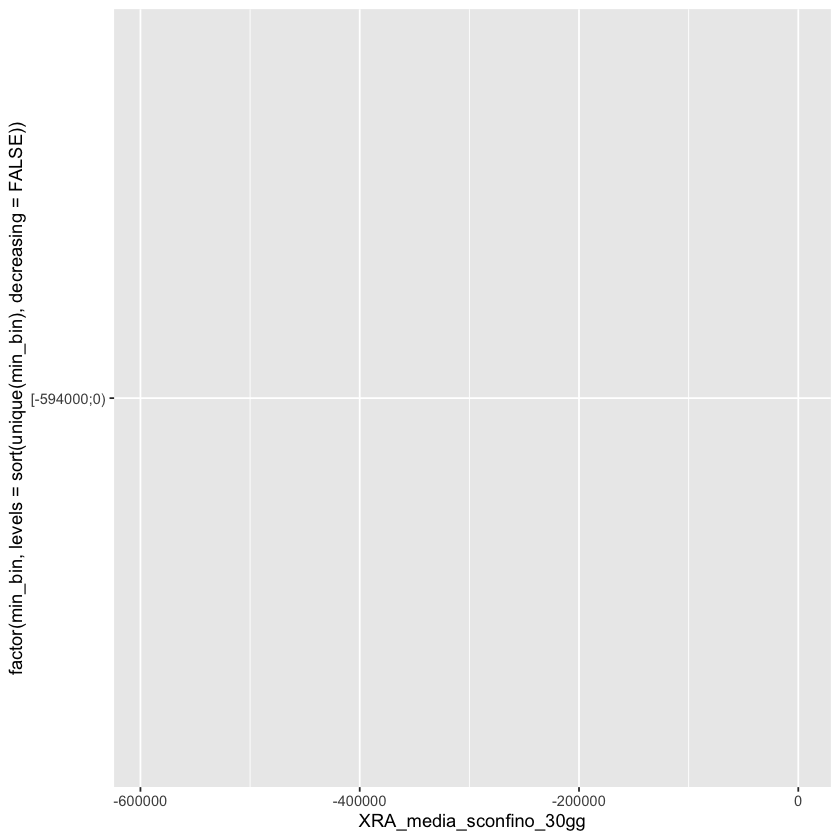

In [16]:
ggplot(data=master_appo, aes(x=XRA_media_sconfino_30gg, y=factor(min_bin, levels= sort(unique(min_bin), decreasing = FALSE))))+ scale_y_discrete( labels= paste0("[",sort(unique(master_appo$min_bin), decreasing = FALSE),
                                             ";",sort(unique(master_appo$max_bin), decreasing = FALSE),")"))

In [17]:
sort(unique(master_appo$bin_lab))

[1] "[-594000,0)"

In [18]:
nome_var <- 'XRA_media_sconfino_30gg'
class(master_modello[[nome_var]])

[1] "numeric"

In [19]:
# lapply(c('XRA_media_sconfino_30gg'),
#     function(nome_var){
#        path<- paste0("./output/plot_correlazione/",nome_var,'.jpeg')
#         master_appo <- copy(master_modello[,c('target',nome_var), with = FALSE])
#          if(class(master_modello[nome_var]) == 'numeric'){
#              print(class(master_modello[nome_var]))
#          }
# #          master_appo[,bin_var := discretize(
# #               get(nome_var),
# #               method = "frequency",
# #               breaks = 5)]
         
# #             df <- master_appo[, 
# #         .(tot = .N, ok = sum(target !='DEFAULT'), DEFAULT = sum(target =='DEFAULT'), 
# #           td = 100*sum(target =='DEFAULT')/.N), by = bin_var]
        
# #         df[,color := 'A']
# #         df[td < 100*sum(DEFAULT)/sum(tot), color := 'B']
# #         df[,perc_sample :=round(100*tot/sum(tot),3)]
# #         df
        
# #         p<-ggplot(data=df, aes(x=reorder(bin_var,td), y=td, fill = color)) +
# #           geom_bar(stat="identity") + coord_flip()  + scale_fill_manual(values=c("A"='red3', 'B' = "forestgreen"))+geom_text(aes(label=perc_sample), hjust=-0.1)
# #     p
#             })

In [20]:
table(dt_orig[as.Date(`Esito - RATING SCADUTO`) ==as.Date('9999-12-31'),RATING], useNA = 'always')


    D    UR  <NA> 
   29 36822  1214 

In [21]:
dt_DSI <- readRDS('../../../data/RDS/master/sme/master_dsi.RDS')

In [22]:
colnames(dt_orig)[grepl('RATING',colnames(dt_orig))]

[1] "Colore - RATING SCADUTO"     "Esito - RATING SCADUTO"     
 [3] "Input - RATING SCADUTO"      "PREFISSO_MOD_RATING_CEDUTO" 
 [5] "MODELLO_RATING_CEDUTO"       "RATING_CEDUTO"              
 [7] "PREFISSO_MOD_RATING_CEDENTE" "MODELLO_RATING_CEDENTE"     
 [9] "RATING_CEDENTE"              "RATING_APPOGGIO"            
[11] "RATING_APPOGGIO2"            "RATING"                     
[13] "CLUSTER_RATING_FASCIA"

In [23]:
str(head(dt_orig[,`Esito - RATING SCADUTO`]))

 POSIXct[1:6], format: "9999-12-31" "9999-12-31" "2020-12-31" "2020-12-31" "2020-12-31" ...


In [24]:
table(master_modello$DSI_rapporti_in_osservazione)


 -100     0     1     2     3     4     6     8 
52204 36136   194   103    37    10     1     1 